In [3]:
# --- Import des bibliothèques ---
import pandas as pd
import os
import h5py
import numpy as np
import pickle
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

# --- Parcourir les fichiers du dossier ---
root_dataset = '/content/drive/MyDrive/defi-ia-2025-cnes'
for dirname, _, filenames in os.walk(root_dataset):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Import des fichiers
spectra_train = np.load(f'{root_dataset}/spectra.npy')
auxiliary_train = pd.read_csv(f'{root_dataset}/auxiliary.csv')
targets_train = pd.read_csv(f'{root_dataset}/targets.csv')

print("spectra_train shape:", spectra_train.shape)
print("auxiliary_train shape:", auxiliary_train.shape)
print("targets_train shape:", targets_train.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/defi-ia-2025-cnes/spectra.npy
/content/drive/MyDrive/defi-ia-2025-cnes/spectra_test.npy
/content/drive/MyDrive/defi-ia-2025-cnes/auxiliary_test.csv
/content/drive/MyDrive/defi-ia-2025-cnes/auxiliary.csv
/content/drive/MyDrive/defi-ia-2025-cnes/targets.csv
spectra_train shape: (3000, 52, 3)
auxiliary_train shape: (3000, 5)
targets_train shape: (3000, 3)


In [4]:
spectra_train[2999].shape

(52, 3)

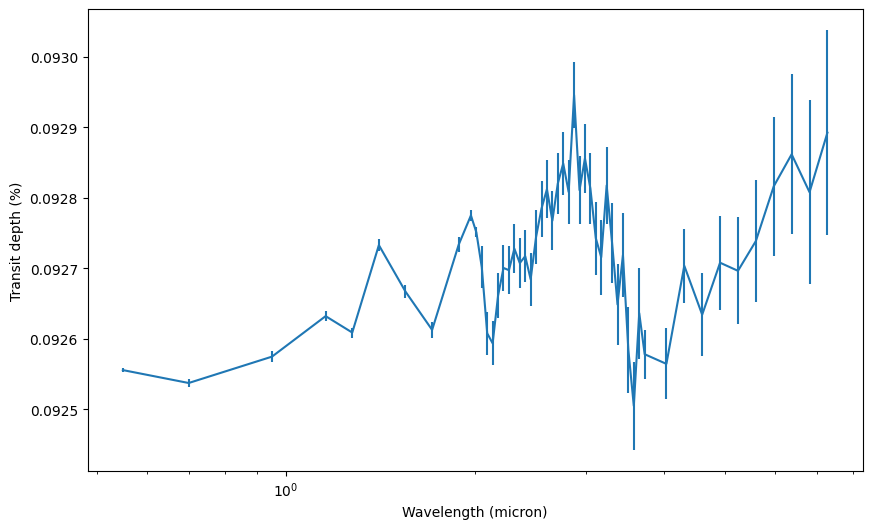

In [5]:
def visualise_spectrum(spectrum):
    ## Multipication par 100 pour passer en pourcentage
    plt.errorbar(x=spectrum[:,0], y= spectrum[:,1]*100, yerr=spectrum[:,2]*100 )
    ## On a l'habitude de lire les spectres en échelle log
    plt.xscale('log')
    plt.xlabel('Wavelength (micron)')
    plt.ylabel('Transit depth (%)')

fig = plt.figure(figsize=(10,6))
visualise_spectrum(spectra_train[1])
plt.show()

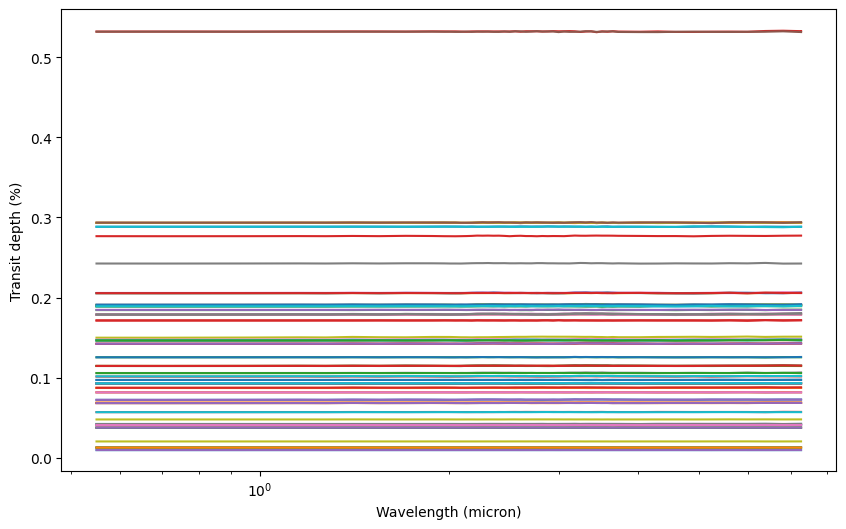

In [6]:
fig = plt.figure(figsize=(10,6))
for i in range(0, 100):
    visualise_spectrum(spectra_train[i])
plt.show()

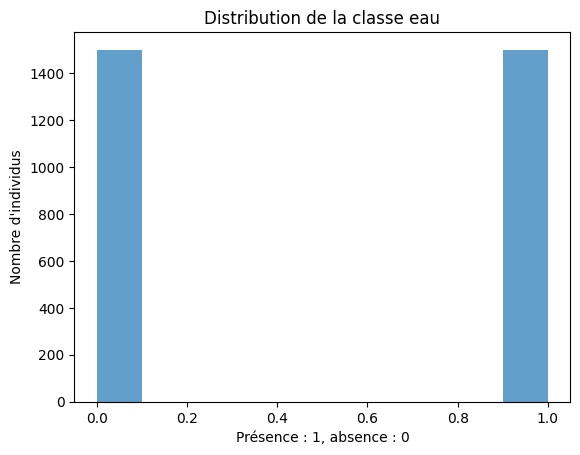

In [7]:
plt.hist(targets_train['eau'], alpha=0.7)
plt.title(f'Distribution de la classe eau')
plt.xlabel('Présence : 1, absence : 0')
plt.ylabel('Nombre d\'individus')
plt.show()

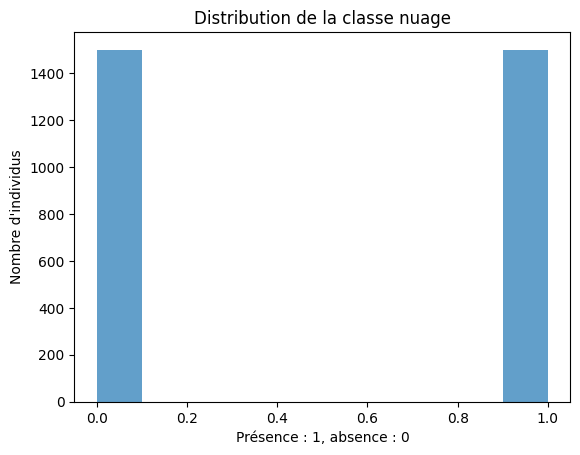

In [8]:
plt.hist(targets_train['nuage'], alpha=0.7)
plt.title(f'Distribution de la classe nuage')
plt.xlabel('Présence : 1, absence : 0')
plt.ylabel('Nombre d\'individus')
plt.show()

In [9]:
RJUP = 69911000
MJUP = 1.898e27
RSOL = 696340000
MSOL = 1.9891e30

In [10]:
auxiliary_train["planet_surface_gravity"] = 20
# calcul du rayon théorique
auxiliary_train["th_radius"] = np.sqrt(auxiliary_train["planet_mass_kg"]*6.67e-11/auxiliary_train["planet_surface_gravity"])/RJUP
auxiliary_train['star_radius'] = auxiliary_train['star_radius_m']/RSOL # Changement de mètre en proprotion du rayon solaire

auxiliary_train['planet_mass'] = auxiliary_train['planet_mass_kg']/MJUP # Changement de kilos vers proportion de masse de jupiter
auxiliary_train['star_mass'] = auxiliary_train['star_mass_kg']/MSOL # Changement de kilos vers proportion de masse solaire


useful_aux_columns = ["star_radius", "star_temperature", "planet_mass", "semi_major_axis_m", "star_mass", "th_radius"]


auxiliary_train = auxiliary_train[useful_aux_columns]
auxiliary_train


,star_radius,star_temperature,planet_mass,semi_major_axis_m,star_mass,th_radius
0,0.710002,5033.0,0.066516,2.277510e+10,0.789722,0.293505
1,0.850002,5320.0,0.020861,1.217744e+10,0.859697,0.164369
2,0.550002,3985.0,0.047197,1.057672e+10,0.579796,0.247234
3,0.210001,2988.0,0.020074,1.431672e+10,0.189933,0.161240
4,0.640002,4925.0,0.044051,1.795200e+10,0.689757,0.238851
...,...,...,...,...,...,...
2995,0.850002,5320.0,0.020861,1.217744e+10,0.859697,0.164369
2996,0.650002,4316.0,0.012145,1.171368e+10,0.649771,0.125417
2997,1.120003,6169.0,0.083602,4.425168e+10,1.099613,0.329047
2998,0.550002,3985.0,0.047197,1.057672e+10,0.579796,0.247234


In [11]:
spectra_data = spectra_train[:,:,1]
error_data = spectra_train[:,:,2]

In [12]:
import numpy as np
from sklearn.utils import shuffle

def physical_augmentation_internal(signal, error, aux, targets, multiplier=1, noise_factor=0.5):
    """
    Augmente les spectres en utilisant l'erreur instrumentale.
    Gère correctement les targets 1D ou 2D et empêche les valeurs négatives.
    """
    n_samples, n_features = signal.shape
    total_size = n_samples * (multiplier + 1)

    new_signals = np.empty((total_size, n_features), dtype=np.float32)
    new_aux     = np.empty((total_size, aux.shape[1]), dtype=np.float32)

    if targets.ndim == 1:
        new_targets = np.empty((total_size,), dtype=targets.dtype)
    else:
        new_targets = np.empty((total_size, targets.shape[1]), dtype=targets.dtype)

    new_signals[:n_samples] = signal
    new_aux[:n_samples]     = aux
    new_targets[:n_samples] = targets

    for i in range(multiplier):
        start = n_samples * (i + 1)
        end   = n_samples * (i + 2)

        # Bruit proportionnel à l'erreur instrumentale
        noise = np.random.randn(n_samples, n_features) * error * noise_factor

        aug_signal = signal + noise

        aug_signal = np.maximum(aug_signal, 0)

        new_signals[start:end] = aug_signal

        # Copie des données invariantes
        new_aux[start:end]     = aux
        new_targets[start:end] = targets

    return shuffle(new_signals, new_aux, new_targets, random_state=42)

In [13]:
from sklearn.preprocessing import Normalizer, StandardScaler

def preprocess_inside_loop(X_spec, X_aux):
    # 1. Normalisation L2 sur les spectres (indispensable pour l'intensité)
    norm = Normalizer(norm='l2')
    X_spec_norm = norm.transform(X_spec)

    # 2. Standardisation sur les auxiliaires
    scaler = StandardScaler()
    X_aux_norm = scaler.fit_transform(X_aux) # Fit sur le batch courant

    # 3. Concaténation
    return np.hstack([X_spec_norm, X_aux_norm]), scaler # On renvoie le scaler si besoin pour le test

In [14]:
X_spectres_np = np.asarray(spectra_data)
X_error_np    = np.asarray(error_data)
X_aux_np      = np.asarray(auxiliary_train)
Y_train_np    = np.asarray(targets_train.values[:,1:])

**Analyse des variables importantes pour XgBoost**

🔬 Analyse Forensique pour la Cible 1...
🧠 Entraînement du modèle diagnostic...
📊 Erreurs : 8 Faux Positifs | 6 Faux Négatifs


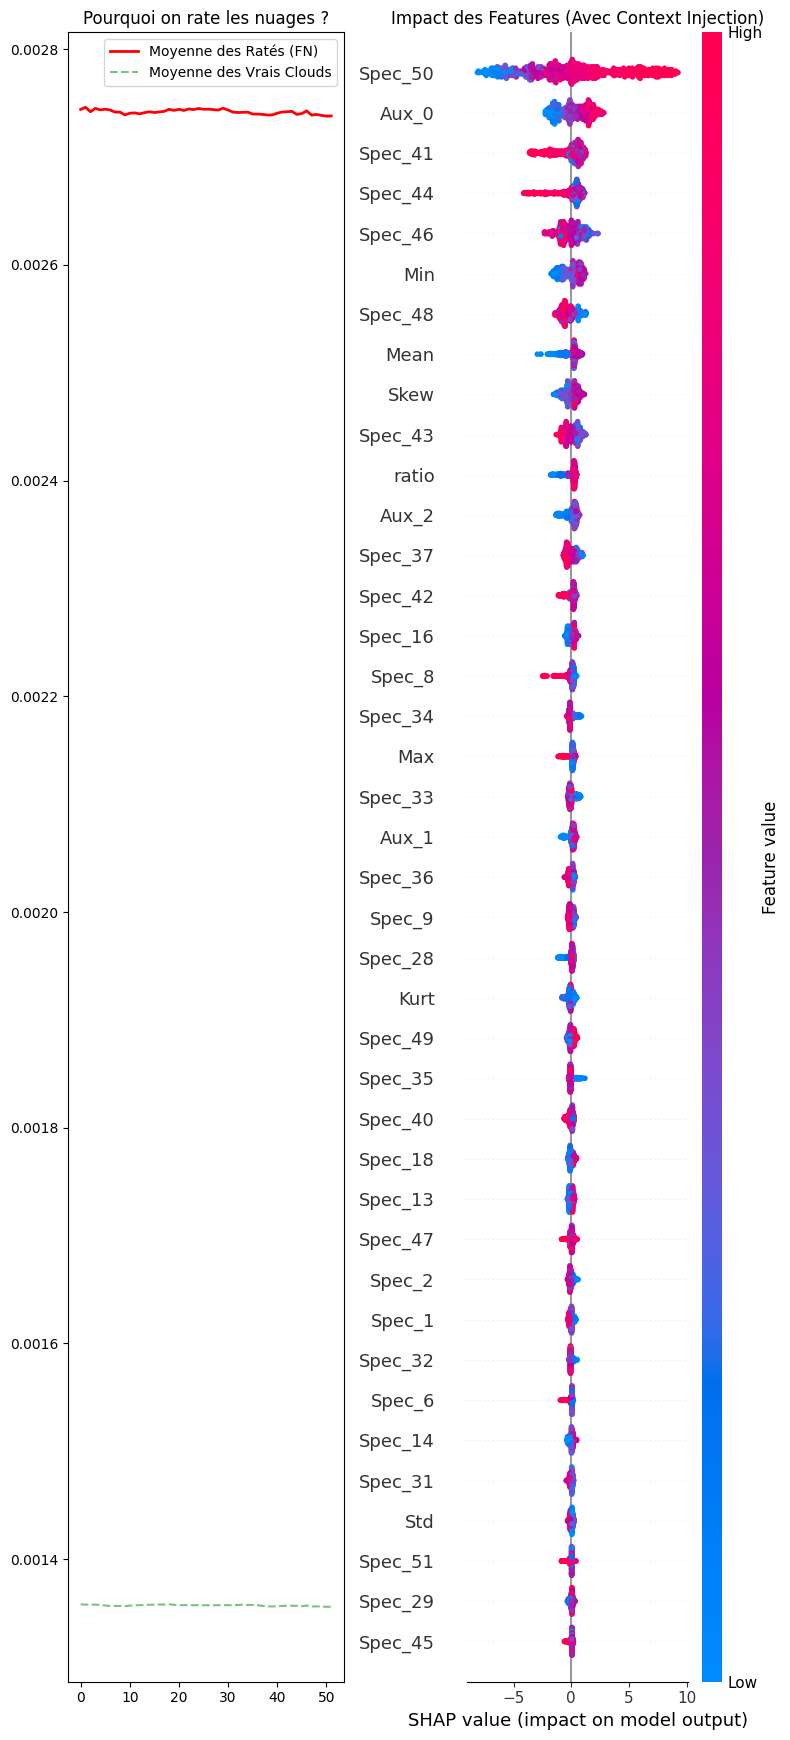

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler
from scipy.stats import skew, kurtosis

PARAMS_DIAG = {
    'n_estimators': 1000, # Suffisant pour voir les features importantes
    'learning_rate': 0.05,
    'max_depth': 5,
    'tree_method': 'hist',
    'eval_metric': 'logloss',
    'early_stopping_rounds': 50,
    'n_jobs': -1
}

TARGET_IDX = 1 # 1 -> nuages 0 -> H2o
def get_physics_features(spectra):
    # Vos stats classiques
    f_mean = np.mean(spectra, axis=1).reshape(-1, 1)
    f_std  = np.std(spectra, axis=1).reshape(-1, 1)
    f_max  = np.max(spectra, axis=1).reshape(-1, 1)
    f_min  = np.min(spectra, axis=1).reshape(-1, 1)
    f_skew = skew(spectra, axis=1).reshape(-1, 1)
    f_kurt = kurtosis(spectra, axis=1).reshape(-1, 1)
    f_slope = (spectra[:, -1] - spectra[:, 0]).reshape(-1, 1)
    ratio_depth = f_min / (f_max + 1e-6)
    # Ratio d'amplitude (Contraste)
    f_contrast = (f_max - f_min) / (f_mean + 1e-6)
    return np.hstack([f_mean, ratio_depth, f_std, f_max, f_min, f_skew, f_kurt, f_slope, f_contrast])

print(f"🔬 Analyse Forensique pour la Cible {TARGET_IDX}...")
y_target = Y_train_np[:, TARGET_IDX]

# Split Analyse (80/20)
X_s_tr, X_s_val, X_a_tr, X_a_val, y_tr, y_val = train_test_split(
    X_spectres_np, X_aux_np, y_target, test_size=0.2, random_state=42, stratify=y_target
)

# Physics Features
phys_tr  = get_physics_features(X_s_tr)
phys_val = get_physics_features(X_s_val)

# Normalisation L2
norm = Normalizer(norm='l2')
X_spec_tr_norm = norm.fit_transform(X_s_tr)
X_spec_val_norm = norm.transform(X_s_val)

# Scaling des Auxiliaires + Physics + Z-Features
X_extra_tr = np.hstack([X_a_tr, phys_tr])
X_extra_val = np.hstack([X_a_val, phys_val])

scaler_aux = StandardScaler()
X_extra_tr_sc = scaler_aux.fit_transform(X_extra_tr)
X_extra_val_sc = scaler_aux.transform(X_extra_val)

X_train_final = np.hstack([X_spec_tr_norm, X_extra_tr_sc])
X_val_final   = np.hstack([X_spec_val_norm,   X_extra_val_sc])
# Entrainement du modèle
clf = xgb.XGBClassifier(**PARAMS_DIAG, random_state=42)
clf.fit(X_train_final, y_tr, eval_set=[(X_val_final, y_val)], verbose=False)

# Prédictions
y_pred = clf.predict(X_val_final)
fp_idx = np.where((y_pred == 1) & (y_val == 0))[0]
fn_idx = np.where((y_pred == 0) & (y_val == 1))[0]

print(f" Erreurs : {len(fp_idx)} Faux Positifs | {len(fn_idx)} Faux Négatifs")

plt.figure(figsize=(15, 6))
# Graphe des RATÉS (Faux Négatifs)
plt.subplot(1, 2, 1)
if len(fn_idx) > 0:
    # On trace les spectres BRUTS pour voir l'intensité réelle
    plt.plot(np.mean(X_s_val[fn_idx], axis=0), color='red', linewidth=2, label="Moyenne des Ratés (FN)")
    plt.plot(np.mean(X_s_val[y_val==1], axis=0), color='green', linestyle='--', alpha=0.5, label="Moyenne des Vrais Clouds")
plt.title("Pourquoi on rate les nuages ?")
plt.legend()

# Graphe SHAP
plt.subplot(1, 2, 2)
# Construction des noms de features pour que ce soit lisible
feat_names = [f"Spec_{i}" for i in range(52)] + \
             [f"Aux_{i}" for i in range(X_a_tr.shape[1])] + \
             ["Mean", "ratio", "Std", "Max", "Min", "Skew", "Kurt", "Slope", "Contrast"]

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_val_final)

# On affiche le top 20
shap.summary_plot(shap_values, X_val_final, feature_names=feat_names, plot_type="dot", max_display=40, show=False)
plt.title("Impact des Features (Avec Context Injection)")
plt.tight_layout()
plt.show()

**XGBoost**

In [16]:
from scipy.stats import skew, kurtosis

def get_features(spectra):
    eps = 1e-6
    # 1. Les Stats Globales (Celles qui marchaient !)
    f_mean = np.mean(spectra, axis=1).reshape(-1, 1)
    f_max  = np.max(spectra, axis=1).reshape(-1, 1)
    f_min  = np.min(spectra, axis=1).reshape(-1, 1)
    f_skew = skew(spectra, axis=1).reshape(-1, 1)
    f_kurt = kurtosis(spectra, axis=1).reshape(-1, 1)
    ratio_depth = f_min / (f_max + eps)

    # On retourne TOUT ensemble
    return np.hstack([f_mean, ratio_depth, f_max, f_min, f_skew, f_kurt])

In [17]:
from scipy.stats import skew,kurtosis
from scipy.stats import entropy
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
def train_cv_advanced_physics(raw_spec, raw_err, raw_aux, y_target, name, custom_params=None):

    if custom_params is None: current_params = PARAMS_BEST
    else: current_params = custom_params


    oof_preds = np.zeros(len(y_target))
    scores = []
    saved_artifacts = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(raw_spec, y_target)):

        # SPLIT
        X_s_t, X_e_t, X_a_t, Y_t = raw_spec[train_idx], raw_err[train_idx], raw_aux[train_idx], y_target[train_idx]
        X_s_v, X_a_v, Y_v        = raw_spec[val_idx],   raw_aux[val_idx],   y_target[val_idx]

        # AUGMENTATION
        X_s_t_aug, X_a_t_aug, Y_t_aug = physical_augmentation_internal(
            X_s_t, X_e_t, X_a_t, Y_t, multiplier=4, noise_factor=0.5
        )

        phys_train = get_features(X_s_t_aug)
        phys_val   = get_features(X_s_v)


        # On ajoute tout ça aux auxiliaires
        X_a_t_final = np.hstack([X_a_t_aug, phys_train])
        X_a_v_final = np.hstack([X_a_v, phys_val])

        # PREPROCESSING
        norm = Normalizer(norm='l2')
        X_spec_train = norm.transform(X_s_t_aug)
        X_spec_val   = norm.transform(X_s_v)

        scaler_aux = StandardScaler()
        X_aux_train = scaler_aux.fit_transform(X_a_t_final)
        X_aux_val   = scaler_aux.transform(X_a_v_final)

        # TRAIN
        X_train_fold = np.hstack([X_spec_train, X_aux_train])
        X_val_fold   = np.hstack([X_spec_val, X_aux_val])

        clf = XGBClassifier(**current_params, random_state=fold)
        clf.fit(X_train_fold, Y_t_aug, eval_set=[(X_val_fold, Y_v)], verbose=False)

        score = clf.best_score
        scores.append(score)
        oof_preds[val_idx] = clf.predict_proba(X_val_fold)[:, 1]

        # On sauvegarde le scaler qui connaît maintenant 3 colonnes de plus !
        saved_artifacts.append({'model': clf, 'scaler_aux': scaler_aux})

        print(f"  Fold {fold+1} -> LogLoss: {score:.5f}")

    print(f"✅ Moyenne LogLoss {name}: {np.mean(scores):.5f}")
    return oof_preds, saved_artifacts

In [18]:
# CONFIGURATION
PARAMS_BEST = {
    'n_estimators': 10000,
    'learning_rate': 0.01,
    'min_child_weight': 5,
    'max_depth': 4,
    'subsample': 0.8, 'colsample_bytree': 0.9,
    'n_jobs': -1, 'tree_method': 'hist',
    'early_stopping_rounds': 750, 'eval_metric': 'logloss'
}

# CLOUDS : Avec la nouvelle fonction et les params robustes
oof_clouds, artifacts_clouds = train_cv_advanced_physics(
    X_spectres_np, X_error_np, X_aux_np, Y_train_np[:, 1],
    name="Clouds", custom_params= PARAMS_BEST)
# H2O : On ne change rien (L'ancienne méthode marche)
oof_h2o, artifacts_h2o = train_cv_advanced_physics(
    X_spectres_np, X_error_np, X_aux_np, Y_train_np[:,0], "H20", custom_params = PARAMS_BEST)

  Fold 1 -> LogLoss: 0.06489
  Fold 2 -> LogLoss: 0.04641
  Fold 3 -> LogLoss: 0.05228
  Fold 4 -> LogLoss: 0.02897
  Fold 5 -> LogLoss: 0.04554
✅ Moyenne LogLoss Clouds: 0.04762
  Fold 1 -> LogLoss: 0.05111
  Fold 2 -> LogLoss: 0.05355
  Fold 3 -> LogLoss: 0.05611
  Fold 4 -> LogLoss: 0.05016
  Fold 5 -> LogLoss: 0.06406
✅ Moyenne LogLoss H20: 0.05500


In [19]:
import numpy as np
from sklearn.metrics import f1_score
def get_best_threshold(y_true, y_proba):
    best_t, best_score = 0.5, 0
    for t in np.arange(0.2, 0.8, 0.01):
        score = f1_score(y_true, (y_proba > t).astype(int))
        if score > best_score:
            best_score = score
            best_t = t
    return best_t, best_score

In [20]:
# Optimisation des seuils sur l'OOF Final
th_h = get_best_threshold(Y_train_np[:, 0], oof_h2o)
th_c = get_best_threshold(Y_train_np[:, 1], oof_clouds)

**Prediction**

In [22]:
root_dataset = '/content/drive/MyDrive/defi-ia-2025-cnes'

spectra_test = np.load(f'{root_dataset}/spectra_test.npy')
test_spectra = spectra_test[:,:,1]

auxiliary_test = pd.read_csv(f'{root_dataset}/auxiliary_test.csv')

auxiliary_test["planet_surface_gravity"] = 20
# calcul du rayon théorique
auxiliary_test["th_radius"] = np.sqrt(auxiliary_test["planet_mass_kg"]*6.67e-11/auxiliary_test["planet_surface_gravity"])/RJUP
auxiliary_test['star_radius'] = auxiliary_test['star_radius_m']/RSOL # Changement de mètre en proprotion du rayon solaire

auxiliary_test['planet_mass'] = auxiliary_test['planet_mass_kg']/MJUP # Changement de kilos vers proportion de masse de jupiter
auxiliary_test['star_mass'] = auxiliary_test['star_mass_kg']/MSOL # Changement de kilos vers proportion de masse solaire


useful_aux_columns = ["star_radius", "star_temperature", "planet_mass", "semi_major_axis_m", "star_mass", "th_radius"]


test_aux = auxiliary_test[useful_aux_columns].values
auxiliary_test[useful_aux_columns]

,star_radius,star_temperature,planet_mass,semi_major_axis_m,star_mass,th_radius
0,0.510001,3476.0,0.019760,4.293520e+09,0.509821,0.159971
1,0.650002,4316.0,0.012145,1.171368e+10,0.649771,0.125417
2,0.640002,4925.0,0.044051,1.795200e+10,0.689757,0.238851
3,0.380001,3506.0,0.015040,1.078616e+10,0.389863,0.139565
4,0.210001,2988.0,0.020074,1.431672e+10,0.189933,0.161240
...,...,...,...,...,...,...
1027,0.650002,4316.0,0.012145,1.171368e+10,0.649771,0.125417
1028,0.600002,4305.0,0.004090,5.871800e+09,0.609785,0.072784
1029,0.380001,3506.0,0.015040,1.078616e+10,0.389863,0.139565
1030,0.650002,4316.0,0.012145,1.171368e+10,0.649771,0.125417


In [23]:
print(f"Histogramme train : {np.histogram(spectra_train)}")
print(f"Histogramme test : {np.histogram(test_spectra)}")

Histogramme train : (array([318000,  12000,  27000,  42000,  33000,  12000,   6000,   6000,
         6000,   6000]), array([3.40494907e-09, 7.27555924e-01, 1.45511184e+00, 2.18266776e+00,
       2.91022368e+00, 3.63777960e+00, 4.36533552e+00, 5.09289144e+00,
       5.82044736e+00, 6.54800328e+00, 7.27555920e+00]))
Histogramme test : (array([16224, 14976,  7488,  7488,  3744,     0,     0,     0,     0,
        3744]), array([0.00022415, 0.00073645, 0.00124876, 0.00176106, 0.00227337,
       0.00278568, 0.00329798, 0.00381029, 0.00432259, 0.0048349 ,
       0.0053472 ]))


In [24]:
np.shape(auxiliary_train)

(3000, 6)

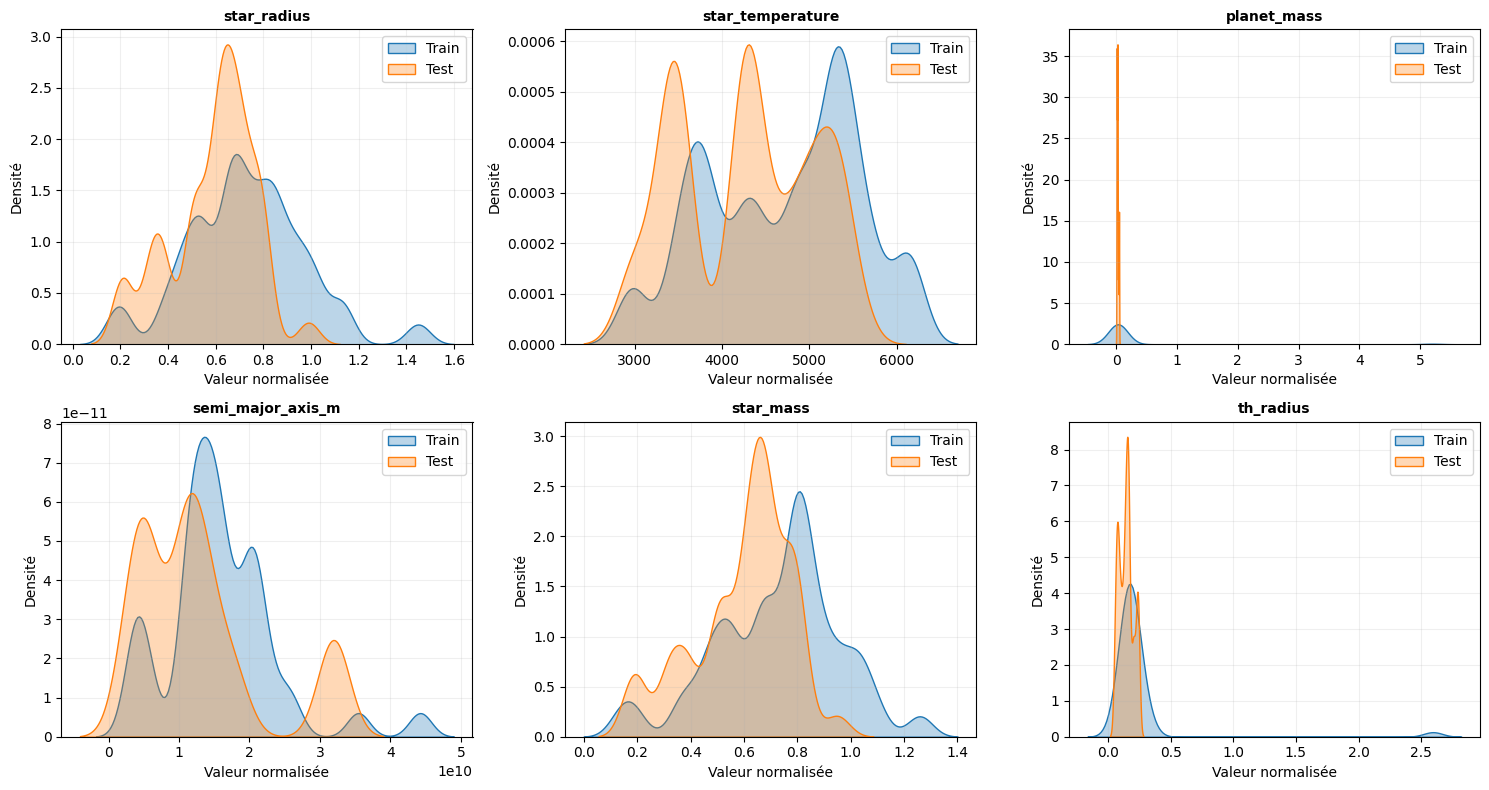

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def comparer_distributions(data_train, data_test, feature_names=None):
    """
    Compare les distributions entre le Train et le Test.
    Gère automatiquement les inputs Numpy ou Pandas.
    """
    # Conversion sécurisée en DataFrame si ce n'est pas déjà le cas
    if not isinstance(data_train, pd.DataFrame):
        data_train = pd.DataFrame(data_train, columns=feature_names)

    if not isinstance(data_test, pd.DataFrame):
        data_test = pd.DataFrame(data_test, columns=feature_names)

    # Si aucun nom n'est fourni et que le dataframe n'en a pas, on met des défauts
    if feature_names is None:
        feature_names = data_train.columns.tolist()

    n_features = len(feature_names)
    cols = 3
    rows = (n_features + cols - 1) // cols

    plt.figure(figsize=(15, 4 * rows))

    for i, col in enumerate(feature_names):
        plt.subplot(rows, cols, i + 1)

        # Plot Train (Bleu)
        sns.kdeplot(data_train[col], label='Train', fill=True, color='#1f77b4', alpha=0.3)
        # Plot Test (Orange)
        sns.kdeplot(data_test[col], label='Test', fill=True, color='#ff7f0e', alpha=0.3)

        plt.title(f"{col}", fontsize=10, fontweight='bold')
        plt.xlabel("Valeur normalisée")
        plt.ylabel("Densité")
        plt.legend()
        plt.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

if hasattr(auxiliary_train, 'columns'):
    noms_aux = auxiliary_train.columns.tolist()
else:
    noms_aux = [
        'Star Temperature',
        'Star Radius',
        'Planet Radius',
        'Planet Mass (or Log g)',
        'Semi-major Axis',
        'Orbital Period'
    ]

comparer_distributions(auxiliary_train, test_aux, noms_aux)

In [38]:
def predict_advanced_physics(artifacts, X_spec_test, X_aux_test, name):
    all_probas = []
    print(f"🧪 Prédiction Advanced Physics ({len(artifacts)} modèles)...")

    # On calcule les features internes une seule fois (car elles ne dépendent pas du fold)
    feat_internal_test = get_features(X_spec_test)

    for i, art in enumerate(artifacts):
        model    = art['model']
        scaler   = art['scaler_aux']
        norm     = art.get('normalizer', Normalizer(norm='l2'))

        X_extra_raw = np.hstack([X_aux_test, feat_internal_test])

        # Scaling
        X_extra_ready = scaler.transform(X_extra_raw)

        X_spec_ready = norm.transform(X_spec_test)

        # Fusion
        X_test_final = np.hstack([X_spec_ready, X_extra_ready])

        # Prédiction
        all_probas.append(model.predict_proba(X_test_final)[:, 1])

    return np.mean(all_probas, axis=0)

In [39]:
print("\n--- Prédiction H2O ---")
final_proba_h2o = predict_advanced_physics(
    artifacts_h2o,
    test_spectra,
    test_aux,
    "H20"
)

print("\n--- Prédiction Clouds ---")
final_proba_clouds = predict_advanced_physics(
    artifacts_clouds,
    test_spectra,
    test_aux,
    "Clouds"
)

print(f"\nSeuils appliqués -> H2O: {th_h[0]:.3f} | Clouds: {th_c[0]:.3f}")

pred_h2o = (final_proba_h2o >= th_h[0]).astype(int)
pred_clouds = (final_proba_clouds >=  th_c[0]).astype(int)


--- Prédiction H2O ---
🧪 Prédiction Advanced Physics (5 modèles)...

--- Prédiction Clouds ---
🧪 Prédiction Advanced Physics (5 modèles)...

Seuils appliqués -> H2O: 0.410 | Clouds: 0.490


In [40]:
submission_df = pd.DataFrame({
    'id': range(len(pred_h2o)),
    'eau': pred_h2o,
    'nuage': pred_clouds
})

submission_df.set_index('id', inplace=True)

submission_df.to_csv("submission.csv")

**Sauvegarde**

In [31]:
np.save(os.path.join(root_dataset, "oof_h2o_xg.npy"), oof_h2o)
np.save(os.path.join(root_dataset, "oof_clouds_xg.npy"), oof_clouds)

In [34]:
np.save(os.path.join(root_dataset, "pred_h2o_xg.npy"), final_proba_h2o)
np.save(os.path.join(root_dataset, "pred_clouds_xg.npy"), final_proba_clouds)